In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
input_path = "/Users/hoapham/Documents/Learning/thesis/data/Binance/agg/500"
symbol = "BNBUSDT"
df = pd.read_csv(f"{input_path}/{symbol}.csv")
try:
    df = df.drop(columns=["Unnamed: 0"])
except:
    pass

In [3]:
cols = [
    "tradeId",
    "price",
    "quantity",
    "firstTradeId",
    "lastTradeId",
    "timestamp",
    "buyerMaker",
    "bestPriceMatch",
]
df.columns = cols
df = df[["timestamp", "price", "quantity", "buyerMaker"]]
df.head()


,timestamp,price,quantity,buyerMaker
0,1757139824320,856.95,0.012,False
1,1757139824807,856.94,0.081,True
2,1757139824897,856.95,0.018,False
3,1757139825301,856.95,0.011,False
4,1757139825328,856.94,0.321,True


In [4]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
df = df[["datetime", "price", "quantity", "buyerMaker"]]
df.head()

,datetime,price,quantity,buyerMaker
0,2025-09-06 06:23:44.320000+00:00,856.95,0.012,False
1,2025-09-06 06:23:44.807000+00:00,856.94,0.081,True
2,2025-09-06 06:23:44.897000+00:00,856.95,0.018,False
3,2025-09-06 06:23:45.301000+00:00,856.95,0.011,False
4,2025-09-06 06:23:45.328000+00:00,856.94,0.321,True


In [5]:
df.tail()

,datetime,price,quantity,buyerMaker
1999995,2025-08-29 13:54:21.108000+00:00,858.17,0.001,True
1999996,2025-08-29 13:54:21.121000+00:00,858.17,0.032,True
1999997,2025-08-29 13:54:21.152000+00:00,858.17,0.021,True
1999998,2025-08-29 13:54:21.152000+00:00,858.16,0.006,True
1999999,2025-08-29 13:54:21.162000+00:00,858.16,0.039,True


In [6]:
df['datetime'] = df['datetime'].dt.floor('S')
df.head()

,datetime,price,quantity,buyerMaker
0,2025-09-06 06:23:44+00:00,856.95,0.012,False
1,2025-09-06 06:23:44+00:00,856.94,0.081,True
2,2025-09-06 06:23:44+00:00,856.95,0.018,False
3,2025-09-06 06:23:45+00:00,856.95,0.011,False
4,2025-09-06 06:23:45+00:00,856.94,0.321,True


- buyerMaker cho biết buyer là maker hay taker:
    - buyerMaker = False → buyer là taker (mua chủ động ăn ask) ⇒ buy-initiated, giá khớp ở ask side
    - buyerMaker = True  → buyer là maker (đặt bid chờ, bị sell chủ động đập vào) ⇒ sell-initiated, giá khớp ở bid side
- => Hướng trade luôn xác định theo bên chủ động (taker).

In [7]:
df['side'] = np.where(df['buyerMaker'], 'sell', 'buy')
df.head()

,datetime,price,quantity,buyerMaker,side
0,2025-09-06 06:23:44+00:00,856.95,0.012,False,buy
1,2025-09-06 06:23:44+00:00,856.94,0.081,True,sell
2,2025-09-06 06:23:44+00:00,856.95,0.018,False,buy
3,2025-09-06 06:23:45+00:00,856.95,0.011,False,buy
4,2025-09-06 06:23:45+00:00,856.94,0.321,True,sell


In [8]:
agg = (df.groupby(['datetime', 'side'])
         .agg(price_mean=('price', 'mean'),
              qty_sum=('quantity', 'sum'))
         .reset_index()
         )

In [9]:
price_wide = agg.pivot(index='datetime', columns='side', values='price_mean').add_prefix('price_')
qty_wide   = agg.pivot(index='datetime', columns='side', values='qty_sum').add_prefix('qty_')


In [10]:
out_df = pd.concat([price_wide, qty_wide], axis=1).fillna(0.0)
for col in ['price_buy', 'price_sell', 'qty_buy', 'qty_sell']:
    if col not in out_df.columns:
        out_df[col] = 0.0
out_df = out_df[['price_buy', 'price_sell', 'qty_buy', 'qty_sell']].sort_index()

In [11]:
out_df

side,price_buy,price_sell,qty_buy,qty_sell
datetime,,,,
2025-08-29 13:52:10+00:00,0.000000,857.871111,0.000,0.399
2025-08-29 13:52:11+00:00,857.810000,857.835000,0.309,0.470
2025-08-29 13:52:12+00:00,857.810000,0.000000,0.321,0.000
2025-08-29 13:52:13+00:00,857.832500,857.850000,0.407,8.462
2025-08-29 13:52:14+00:00,857.897692,857.890000,0.675,0.126
...,...,...,...,...
2025-09-06 06:29:15+00:00,857.640000,0.000000,0.122,0.000
2025-09-06 06:29:16+00:00,857.640000,857.630000,0.070,0.011
2025-09-06 06:29:18+00:00,857.640000,857.630000,0.020,0.352


In [12]:
date_test = out_df.index[-1]
df[df["datetime"] == date_test]

,datetime,price,quantity,buyerMaker,side
999,2025-09-06 06:29:20+00:00,857.64,0.007,False,buy


In [13]:
date_test = out_df.index[0]
df[df["datetime"] == date_test]

,datetime,price,quantity,buyerMaker,side
1999000,2025-08-29 13:52:10+00:00,857.89,0.053,True,sell
1999001,2025-08-29 13:52:10+00:00,857.88,0.052,True,sell
1999002,2025-08-29 13:52:10+00:00,857.88,0.047,True,sell
1999003,2025-08-29 13:52:10+00:00,857.88,0.073,True,sell
1999004,2025-08-29 13:52:10+00:00,857.87,0.034,True,sell
1999005,2025-08-29 13:52:10+00:00,857.86,0.019,True,sell
1999006,2025-08-29 13:52:10+00:00,857.86,0.060,True,sell
1999007,2025-08-29 13:52:10+00:00,857.86,0.026,True,sell
1999008,2025-08-29 13:52:10+00:00,857.86,0.035,True,sell


In [14]:
# Tính V
out_df["total_qty"] = out_df["qty_buy"] + out_df["qty_sell"]
# resample theo ngày
daily_vol = out_df["total_qty"].resample("D").sum()

# bỏ ngày đầu và ngày cuối vì không đủ dữ liệu
daily_vol = daily_vol.iloc[1:-1]
# Tính Volumn Bucket
V = int(daily_vol.mean() / 50)
out_df = out_df.drop(columns=["total_qty"])
V

2728

In [15]:
out_df.head()

side,price_buy,price_sell,qty_buy,qty_sell
datetime,,,,
2025-08-29 13:52:10+00:00,0.000000,857.871111,0.000,0.399
2025-08-29 13:52:11+00:00,857.810000,857.835000,0.309,0.470
2025-08-29 13:52:12+00:00,857.810000,0.000000,0.321,0.000
2025-08-29 13:52:13+00:00,857.832500,857.850000,0.407,8.462
2025-08-29 13:52:14+00:00,857.897692,857.890000,0.675,0.126


## Tính buckets

In [16]:
def get_buckets(df, bucketSize: float) -> pd.DataFrame:
    d = df.copy()
    buckets = []
    BV = SV = filled = 0.0
    price_num = 0.0  # tích lũy khối lượng * giá (cả buy lẫn sell)

    for ts, row in d.iterrows():
        buy_remain  = float(row['qty_buy'])
        sell_remain = float(row['qty_sell'])
        total_remain = buy_remain + sell_remain

        while total_remain > 0:
            space = bucketSize - filled
            take = min(space, total_remain)  # khối lượng lấy vào bucket ở vòng này

            # phân bổ theo tỷ lệ buy/sell còn lại ở timestamp này
            buy_share = (buy_remain / total_remain) if total_remain > 0 else 0.0
            alloc_buy = take * buy_share
            alloc_sell = take - alloc_buy

            # cộng dồn lượng
            BV += alloc_buy
            SV += alloc_sell

            # cộng dồn (khối lượng * giá) để sau tính giá trung bình theo khối lượng
            if alloc_buy > 0:
                price_num += alloc_buy * float(row['price_buy'])
            if alloc_sell > 0:
                price_num += alloc_sell * float(row['price_sell'])

            # cập nhật phần đã lấp đầy trong bucket & phần còn lại của timestamp
            filled += take
            buy_remain  -= alloc_buy
            sell_remain -= alloc_sell
            total_remain = buy_remain + sell_remain

            # đóng bucket nếu đủ V
            if filled >= bucketSize - 1e-12:
                total_vol = BV + SV
                avg_price = (price_num / total_vol) if total_vol > 0 else np.nan
                buckets.append({'Time': ts, 'Buy': BV, 'Sell': SV, 'Price': avg_price})
                # reset cho bucket kế tiếp
                BV = SV = filled = 0.0
                price_num = 0.0

    out = pd.DataFrame(buckets)
    if not out.empty:
        out = out.set_index('Time')
    return out


In [17]:
df_buckets = get_buckets(out_df, V)
df_buckets["volumn"] = df_buckets["Buy"] + df_buckets["Sell"]
df_buckets

,Buy,Sell,Price,volumn
Time,,,,
2025-08-29 14:00:13+00:00,1482.123412,1245.876588,857.612872,2728.0
2025-08-29 14:06:25+00:00,1090.778868,1637.221132,856.005915,2728.0
2025-08-29 14:11:38+00:00,1164.764469,1563.235531,854.019007,2728.0
2025-08-29 14:20:33+00:00,1499.811251,1228.188749,856.782056,2728.0
2025-08-29 14:32:51+00:00,1333.507767,1394.492233,859.491483,2728.0
...,...,...,...,...
2025-09-06 04:17:18+00:00,1660.163910,1067.836090,859.021905,2728.0
2025-09-06 04:41:53+00:00,1320.098429,1407.901571,858.630522,2728.0
2025-09-06 04:52:47+00:00,1680.179679,1047.820321,857.018840,2728.0


In [18]:
def calc_vpin(df, bucketSize, window):
    df_buckets = get_buckets(df, bucketSize)

    # VPIN: rolling mean của |Buy - Sell| / V
    df_buckets['VPIN'] = (abs(df_buckets['Buy'] - df_buckets['Sell']) / bucketSize).rolling(window).mean()

    # CDF:
    df_buckets['CDF'] = df_buckets['VPIN'].rank(pct=True)

    return df_buckets


In [19]:
vpin_df = calc_vpin(out_df, V, 50)

In [20]:
vpin_df

,Buy,Sell,Price,VPIN,CDF
Time,,,,,
2025-08-29 14:00:13+00:00,1482.123412,1245.876588,857.612872,NaN,NaN
2025-08-29 14:06:25+00:00,1090.778868,1637.221132,856.005915,NaN,NaN
2025-08-29 14:11:38+00:00,1164.764469,1563.235531,854.019007,NaN,NaN
2025-08-29 14:20:33+00:00,1499.811251,1228.188749,856.782056,NaN,NaN
2025-08-29 14:32:51+00:00,1333.507767,1394.492233,859.491483,NaN,NaN
...,...,...,...,...,...
2025-09-06 04:17:18+00:00,1660.163910,1067.836090,859.021905,0.167788,0.997050
2025-09-06 04:41:53+00:00,1320.098429,1407.901571,858.630522,0.166923,0.988201
2025-09-06 04:52:47+00:00,1680.179679,1047.820321,857.018840,0.166982,0.991150


In [21]:
def plot_vpin(buckets):
    """
    buckets: DataFrame từ calc_vpin (có cột 'VPIN')
    """
    plt.figure(figsize=(12,6))
    plt.plot(buckets.index, buckets['VPIN'], label='VPIN', linewidth=1.5)
    plt.title("VPIN over time")
    plt.xlabel("Time")
    plt.ylabel("VPIN")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


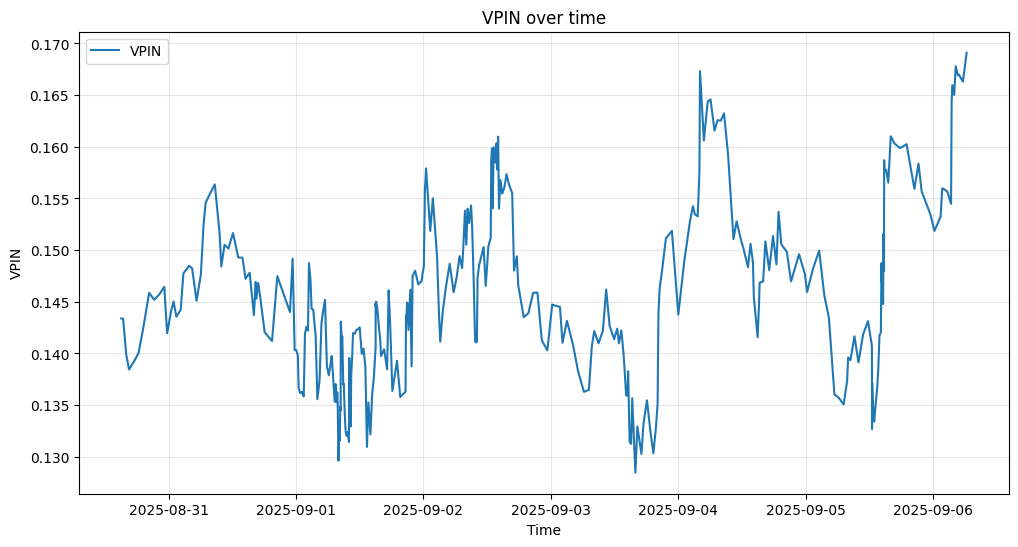

In [22]:
plot_vpin(vpin_df)